# Differential Data Augmentation Techniques for Medical Imaging Classification
#### Gaussian Noise Augmentation Model Notebook

## Import Packages

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split, TensorDataset, DataLoader
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

# Imports for plotting
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

# Imports for Loading Data
import tensorflow as tf
import cv2

# Imports for Model Validations
from sklearn.metrics import accuracy_score, precision_score, roc_curve
from sklearn.metrics import recall_score, f1_score, confusion_matrix, roc_auc_score

# Data Wranging

In [2]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [3]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(224,224))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
filenames=['/content/drive/MyDrive/Colab Notebooks/ECE_661_Final_Project_Data/training10_0.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_1.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_2.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_3.tfrecords'
         # ,'/content/drive/MyDrive/Colab Notebooks/ECE661_FinalProject/Data/training10_4.tfrecords'
         ]

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
11177
11177


## Create Train-Val-Test Split 

### Get 1000 True cases and 1000 False cases

In [6]:
Y = pd.DataFrame({'Y':labels})
true_cases = list(Y[Y['Y'] == 1].copy().index)[0:1000]
false_cases = list(Y[Y['Y'] == 0].copy().index)[0:1000]
ind = true_cases + false_cases
print(len(ind))

2000


In [7]:
y = np.array([labels[i] for i in ind])
X = np.array([images[i] for i in ind])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y ,random_state=2021,shuffle=True)

In [9]:
print('80-20 Split')
print('X-Train Shape: ', x_train.shape)
print('X-Test Shape: ', x_test.shape)

80-20 Split
X-Train Shape:  (1600, 224, 224, 3)
X-Test Shape:  (400, 224, 224, 3)


### Create Custom Tensor Dataset (To Allow for Transform data augmentation techniques)

In [10]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


### Calculate Mean and Std For Transform Method

In [11]:
# nimages = 0
# mean = 0.0
# var = 0.0

# for i_batch, batch_target in enumerate(train_dataloader):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0) 
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print(mean)
# print(std)

Normalization Metrics from running the above code snippet: 

Mean: tensor([105.7823, 105.7823, 105.7823])


Std: tensor([26.6096, 26.6096, 26.6096])

### Add Gaussian Noise Transformation Class

In [12]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:

def data_input(c):
  # Define preprocessing
  trsfm = transforms.Compose([
          transforms.ToPILImage(),
          transforms.ToTensor(),
          #transforms.Normalize((105.7823, 105.7823, 105.7823), (26.6096, 26.6096, 26.6096)),
          transforms.ColorJitter(contrast=c)
        ])

  # Train
  tensor_trainX = torch.Tensor(x_train) # transform to torch tensor
  tensor_trainY = torch.Tensor(y_train)
  tensor_trainX = tensor_trainX.permute(0, 3, 1, 2)

  # Test
  tensor_testX = torch.Tensor(x_test) # transform to torch tensor
  tensor_testY = torch.Tensor(y_test)
  tensor_testX = tensor_testX.permute(0, 3, 1, 2)


  train_tensor = CustomTensorDataset(tensors=(tensor_trainX,tensor_trainY), transform=trsfm)
  #train_dataloader = DataLoader(train_tensor, batch_size=64, shuffle=False) # create your dataloader
  train_tensor_normal = CustomTensorDataset(tensors=(tensor_trainX,tensor_trainY), transform=None)
  train=train_tensor+train_tensor_normal

  train_dataloader = DataLoader(train, batch_size=64, shuffle=True) # create your dataloader


  test_tensor = CustomTensorDataset(tensors=(tensor_testX,tensor_testY), transform=None) # create your datset
  test_dataloader = DataLoader(test_tensor, batch_size=64, shuffle=False) # create your dataloader
  # Run this to test your data loader
  images, labels = next(iter(train_dataloader))

  plt.imshow(images[6].permute(1, 2, 0))
  return train_dataloader,test_dataloader

## Create VGG16 model

In [14]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

## Prepare model for Training

In [15]:
def model_definition():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

  model = VGG16() #to compile the model
  model = model.to(device=device) #to send the model for training on either cuda or cpu

  ## Loss and optimizer
  learning_rate = 1e-4 #I picked this because it seems to be the most used by experts
  l2_reg = 1e-7

  load_model = True
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr= learning_rate, weight_decay=l2_reg) #Adam seems to be the most popular for deep learning
  return model,optimizer,criterion,device,learning_rate

In [16]:
def show_plot(train_accur,test_accur,EPOCHS):
  plt.figure(figsize=(8,8))
  plt.plot(range(EPOCHS),train_accur, label='Baseline Model - Training Accuracy')
  plt.plot(range(EPOCHS),test_accur, label='Baseline Model - Testing Accuracy')

  plt.title('Training and Testing Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.legend()
  plt.show()

In [17]:
def calculate_metrics(y_test,best_predictions):
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, best_predictions)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_test, best_predictions)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test, best_predictions)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, best_predictions)
  print('F1 score: %f' % f1)

In [18]:
def confusion_matrix1(y_test,best_predictions):
  unique_label = np.unique([y_test, best_predictions])
  cmtx = pd.DataFrame(
    confusion_matrix(y_test, best_predictions, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
  )

  print(cmtx)

In [19]:
def roc(y_test, best_output_probs):
  fpr, tpr, thresholds = roc_curve(y_test, best_output_probs)
  auc = roc_auc_score(y_test, best_output_probs)
  plt.figure(figsize=(8,8))
  plt.plot(fpr, tpr, label='AUC score is: '+str(round(auc, 4)))
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()

Training 1600 - Constrast 0 (Normal)
          1600 - Contrast 1 (Transformed)
        
Testing: 400 - Constrast 0 (Normal)

## Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Training starts!
The current contrast value: 1
Epoch 0:
Training loss: 0.6890, Training accuracy: 0.5262
Validation loss: 0.7094, Validation accuracy: 0.5000
Saving ...

Epoch 1:
Training loss: 0.5782, Training accuracy: 0.6944
Validation loss: 0.5905, Validation accuracy: 0.6125
Saving ...

Epoch 2:
Training loss: 0.5487, Training accuracy: 0.7163
Validation loss: 0.5333, Validation accuracy: 0.7550
Saving ...

Epoch 3:
Training loss: 0.5306, Training accuracy: 0.7312
Validation loss: 0.5827, Validation accuracy: 0.6575

Epoch 4:
Training loss: 0.5205, Training accuracy: 0.7400
Validation loss: 0.5292, Validation accuracy: 0.7625
Saving ...

Epoch 5:
Training loss: 0.4931, Training accuracy: 0.7650
Validation loss: 0.5112, Validation accuracy: 0.7800
Saving ...

Epoch 6:
Training loss: 0.4873, Training accuracy: 0.7706
Validation loss: 0.5300, Validation accuracy: 0.6850

Epoch 7:
Training loss: 0.4806, Training accuracy: 0.7747
Validation loss: 0.4486, Validation accuracy: 0.7925

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Training starts!
The current contrast value: 5
Epoch 0:
Training loss: 0.6926, Training accuracy: 0.5088
Validation loss: 0.6927, Validation accuracy: 0.5000
Saving ...

Epoch 1:
Training loss: 0.6108, Training accuracy: 0.6619
Validation loss: 0.5483, Validation accuracy: 0.7350
Saving ...

Epoch 2:
Training loss: 0.5468, Training accuracy: 0.7166
Validation loss: 0.5777, Validation accuracy: 0.6600

Epoch 3:
Training loss: 0.5272, Training accuracy: 0.7478
Validation loss: 0.5348, Validation accuracy: 0.7050

Epoch 4:
Training loss: 0.5058, Training accuracy: 0.7369
Validation loss: 0.5202, Validation accuracy: 0.7400
Saving ...

Epoch 5:
Training loss: 0.4851, Training accuracy: 0.7703
Validation loss: 0.5007, Validation accuracy: 0.7800
Saving ...

Epoch 6:
Training loss: 0.4986, Training accuracy: 0.7569
Validation loss: 0.4965, Validation accuracy: 0.7750

Epoch 7:
Training loss: 0.4576, Training accuracy: 0.7844
Validation loss: 0.4209, Validation accuracy: 0.8400
Saving ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Training starts!
The current contrast value: 15
Epoch 0:
Training loss: 0.6813, Training accuracy: 0.5547
Validation loss: 0.6696, Validation accuracy: 0.5925
Saving ...

Epoch 1:
Training loss: 0.6270, Training accuracy: 0.6622
Validation loss: 0.5916, Validation accuracy: 0.6650
Saving ...

Epoch 2:
Training loss: 0.5579, Training accuracy: 0.7109
Validation loss: 0.7520, Validation accuracy: 0.5200

Epoch 3:
Training loss: 0.5448, Training accuracy: 0.7306
Validation loss: 0.5526, Validation accuracy: 0.7325
Saving ...

Epoch 4:
Training loss: 0.5048, Training accuracy: 0.7544
Validation loss: 0.5727, Validation accuracy: 0.6625

Epoch 5:
Training loss: 0.5008, Training accuracy: 0.7494
Validation loss: 0.5739, Validation accuracy: 0.6500

Epoch 6:
Training loss: 0.4977, Training accuracy: 0.7516
Validation loss: 0.4939, Validation accuracy: 0.7350
Saving ...

Epoch 7:
Training loss: 0.4619, Training accuracy: 0.7791
Validation loss: 0.4944, Validation accuracy: 0.7325

Epoch 8:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Training starts!
The current contrast value: 20
Epoch 0:
Training loss: 0.6842, Training accuracy: 0.5184
Validation loss: 0.6066, Validation accuracy: 0.7150
Saving ...

Epoch 1:
Training loss: 0.6241, Training accuracy: 0.6531
Validation loss: 0.6214, Validation accuracy: 0.6175

Epoch 2:
Training loss: 0.6033, Training accuracy: 0.6494
Validation loss: 0.6706, Validation accuracy: 0.5075

Epoch 3:
Training loss: 0.5991, Training accuracy: 0.6728
Validation loss: 0.6847, Validation accuracy: 0.6025

Epoch 4:
Training loss: 0.6049, Training accuracy: 0.6541
Validation loss: 0.6457, Validation accuracy: 0.7425
Saving ...

Epoch 5:
Training loss: 0.5635, Training accuracy: 0.7159
Validation loss: 0.5721, Validation accuracy: 0.6900

Epoch 6:
Training loss: 0.5407, Training accuracy: 0.7288
Validation loss: 0.5744, Validation accuracy: 0.6625

Epoch 7:
Training loss: 0.5162, Training accuracy: 0.7469
Validation loss: 0.5936, Validation accuracy: 0.6375

Epoch 8:
Training loss: 0.5026

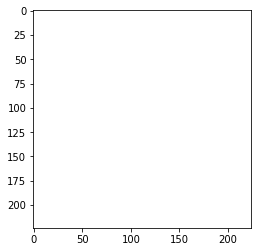

In [20]:
contrast1_output=[]
contrast1_prob_output=[]
contrast1_train_accur=[]
contrast1_test_accur=[]

contrast5_output=[]
contrast5_prob_output=[]
contrast5_train_accur=[]
contrast5_test_accur=[]

contrast10_output=[]
contrast10_prob_output=[]
contrast10_train_accur=[]
contrast10_test_accur=[]

contrast15_output=[]
contrast15_prob_output=[]
contrast15_train_accur=[]
contrast15_test_accur=[]

contrast20_output=[]
contrast20_prob_output=[]
contrast20_train_accur=[]
contrast20_test_accur=[]

for contrast in [1,5,10,15,20]:
  train_dataloader,test_dataloader=data_input(contrast)
  # some hyperparameters
  # total number of training epochs
  model,optimizer,criterion,device,learning_rate=model_definition()
  EPOCHS = 50

  # start the training/validation process
  # the process should take about 5 minutes on a GTX 1070-Ti
  # if the code is written efficiently.
  best_val_acc = 0
  train_accur = []
  test_accur = []

  best_predictions = []
  best_output_probs = []

  print("==> Training starts!")
  print("The current contrast value:", contrast)
  print("="*50)
  for i in range(0, EPOCHS):

      all_predictions = []
      all_outputs = []    
      #######################
      # your code here
      # switch to train mode
      model.train()
      #######################
      
      print("Epoch %d:" %i)
      # this help you compute the training accuracy
      total_examples = 0
      correct_examples = 0

      train_loss = 0 # track training loss if you want
      
      # Train the model for 1 epoch.
      for batch_idx, (inputs, targets) in enumerate(train_dataloader):
          ####################################
          # your code here
          # copy inputs to device
          # Convert to Pytorch (N, C, H, W)
          #inputs = inputs.permute(0, 3, 1, 2)
          images = inputs.to(device)
          # print(batch_idx)
          # print(images.shape)

          targets = targets.to(device=device).long()
          
          # compute the output and loss
          outputs = model(images)
          loss = criterion(outputs, targets)
          
          # zero the gradient
          optimizer.zero_grad()
          
          # backpropagation
          loss.backward()
          
          # apply gradient and update the weights
          optimizer.step()
          _, predicted = torch.max(outputs, 1)
          
          # count the number of correctly predicted samples in the current batch
          correct = predicted.eq(targets).sum()
          
          total_examples += targets.shape[0]
          train_loss += loss
          correct_examples += correct.item()
          
          ####################################
      
      avg_loss = train_loss / len(train_dataloader)
      avg_acc = correct_examples / total_examples
      print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
      train_accur.append(avg_acc)

      # Validate on the validation dataset
      #######################
      # your code here
      # switch to eval mode
      model.eval()
      
      #######################

      # this help you compute the validation accuracy
      total_examples = 0
      correct_examples = 0
      
      val_loss = 0 # again, track the validation loss if you want

      # disable gradient during validation, which can save GPU memory
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(test_dataloader):
              ####################################
              # your code here
              # copy inputs to device
              # Convert to Pytorch (N, C, H, W)
              #inputs = inputs.permute(0, 3, 1, 2)
              images = inputs.to(device)

              targets = targets.to(device=device).long()
              
              # compute the output and loss
              outputs = model(images)
              all_outputs.append(outputs[:,1].cpu().numpy())


              loss = criterion(outputs, targets)
              
              # count the number of correctly predicted samples in the current batch
              _, predicted = torch.max(outputs, 1)
              correct = predicted.eq(targets).sum()
              all_predictions.append(predicted.cpu().numpy())

              total_examples += targets.shape[0]
              val_loss += loss
              correct_examples += correct.item()
              
              ####################################
      
      avg_loss = val_loss / len(test_dataloader)
      avg_acc = correct_examples / total_examples
      print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
      test_accur.append(avg_acc)

      # save the model checkpoint
      if avg_acc > best_val_acc:
          best_val_acc = avg_acc

          all_predictions = np.concatenate(all_predictions).ravel()
          best_predictions = all_predictions

          all_outputs = np.concatenate(all_outputs).ravel()
          best_output_probs = all_outputs

          print("Saving ...")
          state = {'state_dict': model.state_dict(),
                  'epoch': i,
                  'lr': learning_rate}
          torch.save(state,f'contrast-{contrast}_model.pth')
          
      print('')
  if contrast==1:
    print("BEST:",best_predictions)
    contrast1_output.append(best_predictions)
    contrast1_prob_output.append(best_output_probs)
    contrast1_train_accur=train_accur
    contrast1_test_accur=test_accur
    
  elif contrast ==5:    
    contrast5_output.append(best_predictions)
    contrast5_prob_output.append(best_output_probs)
    contrast5_train_accur=train_accur
    contrast5_test_accur=test_accur
    
  elif contrast ==10:    
    contrast10_output.append(best_predictions)
    contrast10_prob_output.append(best_output_probs)
    contrast10_train_accur=train_accur
    contrast10_test_accur=test_accur
    
  elif contrast ==15:    
    contrast15_output.append(best_predictions)
    contrast15_prob_output.append(best_output_probs)
    contrast15_train_accur=train_accur
    contrast15_test_accur=test_accur
    

  elif contrast ==20:    
    contrast20_output.append(best_predictions)
    contrast20_prob_output.append(best_output_probs)
    contrast20_train_accur=train_accur
    contrast20_test_accur=test_accur
    

  print("="*50)
  print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
  #show_plot(train_accur,test_accur,EPOCHS)
  #calculate_metrics(y_test,best_predictions)
  #confusion_matrix1(y_test,best_predictions)
  #roc(y_test, best_output_probs)



In [21]:
c1_df1 = pd.DataFrame({'Epochs':range(EPOCHS), 'train_accur':contrast1_train_accur, 'test_accur':contrast1_test_accur})
c1_df2 = pd.DataFrame({'y_test':y_test, 'best_predictions':contrast1_output[0], 'best_output_probs':contrast1_prob_output[0]})

c5_df1 = pd.DataFrame({'Epochs':range(EPOCHS), 'train_accur':contrast5_train_accur, 'test_accur':contrast5_test_accur})
c5_df2 = pd.DataFrame({'y_test':y_test, 'best_predictions':contrast5_output[0], 'best_output_probs':contrast5_prob_output[0]})

c10_df1 = pd.DataFrame({'Epochs':range(EPOCHS), 'train_accur':contrast10_train_accur, 'test_accur':contrast10_test_accur})
c10_df2 = pd.DataFrame({'y_test':y_test, 'best_predictions':contrast10_output[0], 'best_output_probs':contrast10_prob_output[0]})

c15_df1 = pd.DataFrame({'Epochs':range(EPOCHS), 'train_accur':contrast15_train_accur, 'test_accur':contrast15_test_accur})
c15_df2 = pd.DataFrame({'y_test':y_test, 'best_predictions':contrast15_output[0], 'best_output_probs':contrast15_prob_output[0]})

c20_df1 = pd.DataFrame({'Epochs':range(EPOCHS), 'train_accur':contrast20_train_accur, 'test_accur':contrast20_test_accur})
c20_df2 = pd.DataFrame({'y_test':y_test, 'best_predictions':contrast20_output[0], 'best_output_probs':contrast20_prob_output[0]})



In [24]:
c1_df1.to_csv('train_and_test_over_epochs_cj_c1_model.csv', index=False)
# files.download('train_and_test_over_epochs_cj_c1_model.csv')

c1_df2.to_csv('best_predictions_and_best_prob_cj_c1_model.csv', index=False)
# files.download('best_predictions_and_best_prob_cj_c1_model.csv')


In [25]:
c5_df1.to_csv('train_and_test_over_epochs_cj_c5_model.csv', index=False)
# files.download('train_and_test_over_epochs_cj_c5_model.csv')

c5_df2.to_csv('best_predictions_and_best_prob_cj_c5_model.csv', index=False)
# files.download('best_predictions_and_best_prob_cj_c5_model.csv')


In [26]:
c10_df1.to_csv('train_and_test_over_epochs_cj_c10_model.csv', index=False)
# files.download('train_and_test_over_epochs_cj_c10_model.csv')

c10_df2.to_csv('best_predictions_and_best_prob_cj_c10_model.csv', index=False)
# files.download('best_predictions_and_best_prob_cj_c10_model.csv')


In [27]:
c15_df1.to_csv('train_and_test_over_epochs_cj_c15_model.csv', index=False)
# files.download('train_and_test_over_epochs_cj_c15_model.csv')

c15_df2.to_csv('best_predictions_and_best_prob_cj_c15_model.csv', index=False)
# files.download('best_predictions_and_best_prob_cj_c15_model.csv')


In [28]:
c20_df1.to_csv('train_and_test_over_epochs_cj_c20_model.csv', index=False)
# files.download('train_and_test_over_epochs_cj_c20_model.csv')

c20_df2.to_csv('best_predictions_and_best_prob_cj_c20_model.csv', index=False)
# files.download('best_predictions_and_best_prob_cj_c20_model.csv')


In [ ]:
while True:
  pass

In [ ]:
contrast10_prob_output


[]

# Model Performance Validation

### Training and Testing Accuracy Over Time

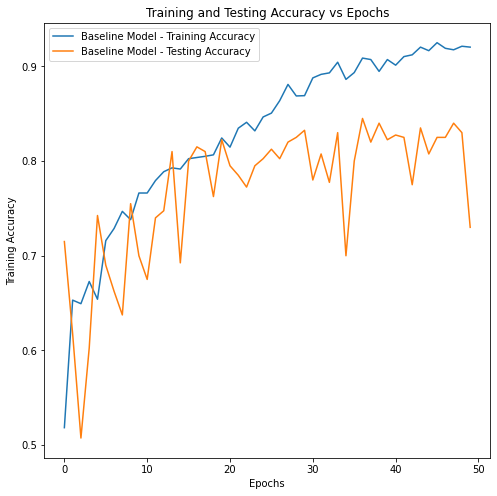

In [29]:
plt.figure(figsize=(8,8))
plt.plot(range(EPOCHS),train_accur, label='Baseline Model - Training Accuracy')
plt.plot(range(EPOCHS),test_accur, label='Baseline Model - Testing Accuracy')

plt.title('Training and Testing Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

### Calculate Accuracy, Precision, Recall, and F1

In [30]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, best_predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, best_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, best_predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, best_predictions)
print('F1 score: %f' % f1)

Accuracy: 0.845000
Precision: 0.870968
Recall: 0.810000
F1 score: 0.839378


### Calculate Confusion Matrix

In [31]:
unique_label = np.unique([y_test, best_predictions])
cmtx = pd.DataFrame(
    confusion_matrix(y_test, best_predictions, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label]
)

cmtx

,pred:0,pred:1
true:0,176,24
true:1,38,162


### Calculate ROC

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, best_output_probs)
auc = roc_auc_score(y_test, best_output_probs)

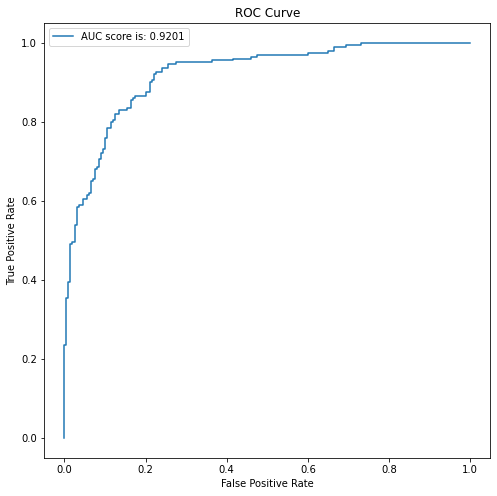

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, best_output_probs)
auc = roc_auc_score(y_test, best_output_probs)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='AUC score is: '+str(round(auc, 4)))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [34]:
auc

0.920075

## Code to dump to help with Report